In [1]:
#Label the data
import pandas as pd
import numpy as np

y= pd.read_csv("/content/Labels.csv")
#Volatility
y['log_returns'] = y['Close'].rolling(window=2).apply(lambda x: np.log(x.iloc[1]/x.iloc[0]))
y['variance'] = y['log_returns'].rolling(window=10).var() # ==> Variance calculation 
y['variance'].fillna(0, inplace=True)
# Direction of the market
y['market_direction'] = y['Close'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] >= x.iloc[0] else 0)

 
y['market_direction'].fillna(0, inplace=True)
# Labelling
y_Volatility = y.reset_index()['variance'] *1000
y_Direction = y.reset_index()['market_direction']

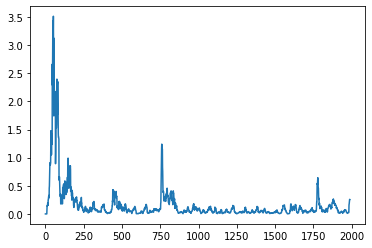

In [2]:
from matplotlib import pyplot as plt 
plt.plot(y_Volatility)

In [3]:
# convert an array of values into a dataset matrix
import numpy as np
def create_dataset(dataset, time_step=3):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [5]:
# choose right objective
y= y_Direction
y=np.array(y).reshape(-1,1)

# prepar the data
time_step = 100
X, y= create_dataset(y,time_step)



In [6]:
# Splitting the data:
num_validation_samples = 100
x_train = X[:-num_validation_samples]
x_val = X[-num_validation_samples:]
y_train = y[:-num_validation_samples]
y_val = y[-num_validation_samples:]

print(x_train.shape), print(y_train.shape)
print(x_val.shape), print(y_val.shape)

(1788, 100)
(1788,)
(100, 100)
(100,)


(None, None)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from matplotlib import pyplot as plt
from sklearn.svm import SVC

# select the model
#model= LogisticRegression()
#model = SVC(kernel='rbf', max_iter=150)
model = RandomForestClassifier(n_estimators=200,criterion='entropy')

#Cross validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#Show box plot of K-fold validation accuracy

print("mean accuracy:", np.mean(scores))
print("standard error:", np.std(scores))

#plt.boxplot(scores)


mean accuracy: 0.5196330068670495
standard error: 0.04769148768863587


Epoch 1/50
143/143 [==============================] - 0s 3ms/step - loss: 1.2464 - accuracy: 0.5084 - val_loss: 1.1103 - val_accuracy: 0.5112
Epoch 2/50
143/143 [==============================] - 0s 2ms/step - loss: 1.0125 - accuracy: 0.5420 - val_loss: 0.9450 - val_accuracy: 0.4944
Epoch 3/50
143/143 [==============================] - 0s 1ms/step - loss: 0.8795 - accuracy: 0.5657 - val_loss: 0.8723 - val_accuracy: 0.4860
Epoch 4/50
143/143 [==============================] - 0s 1ms/step - loss: 0.8101 - accuracy: 0.5517 - val_loss: 0.7942 - val_accuracy: 0.5251
Epoch 5/50
143/143 [==============================] - 0s 1ms/step - loss: 0.7678 - accuracy: 0.5413 - val_loss: 0.7610 - val_accuracy: 0.5251
Epoch 6/50
143/143 [==============================] - 0s 2ms/step - loss: 0.7347 - accuracy: 0.5636 - val_loss: 0.7474 - val_accuracy: 0.5000
Epoch 7/50
143/143 [==============================] - 0s 2ms/step - loss: 0.7213 - accuracy: 0.5538 - val_loss: 0.7437 - val_accuracy: 0.4972
Epoch 

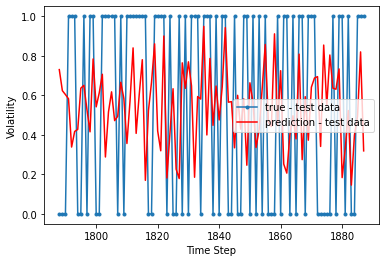

In [12]:
# Simple MLP
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout

input_shape = ( 100,)

# Create the model
model = Sequential()
model.add(Dense(50, kernel_regularizer='l2', input_shape=input_shape, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,  activation='relu'))
model.add(Dropout(0.2))

# binary_crossentropy and sigmoid activation function for classification problem.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#fit the model and statistics are stored in history for analysis
history = model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1, validation_split=0.2)

# Results with MLP
y_pred= model.predict(x_val)

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true - test data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction - test data")
plt.ylabel('Volatility')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();

In [17]:
# MLP with K-fold cross validation
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout

def train_predict_MLP_model(x_train, y_train):


  input_shape = ( 100,)

  # Create the model
  model = Sequential()
  model.add(Dense(50, input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10,  activation='relu'))
  model.add(Dropout(0.2))

  # binary_crossentropy and sigmoid activation function for classification problem.
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1, validation_split=0.2)
  return model


In [18]:
from sklearn.metrics import accuracy_score

trains = []
tests = []
cv = KFold(n_splits=6, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = np.array(X)[train_index], np.array(X)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    
    model = train_predict_MLP_model(X_train, y_train)
    #loss1, accuracy1 = model.evaluate(X_train, y_train)
    loss2, accuracy2 = model.evaluate(X_test, y_test)
    #print(model.metrics_names, accuracy1)
    #print(model.metrics_names, accuracy2)
    #trains.append(accuracy1) # add  squared=True for RMSE
    tests.append(accuracy2)

#print(" TRAIN mean score with std error:", np.mean(trains), np.std(trains))
print(" TEST mean score with std error:", np.mean(tests), np.std(tests))

Epoch 1/50
126/126 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5119 - val_loss: 0.6938 - val_accuracy: 0.4984
Epoch 2/50
126/126 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.5541 - val_loss: 0.6976 - val_accuracy: 0.5206
Epoch 3/50
126/126 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5413 - val_loss: 0.6958 - val_accuracy: 0.5175
Epoch 4/50
126/126 [==============================] - 0s 2ms/step - loss: 0.6847 - accuracy: 0.5405 - val_loss: 0.6935 - val_accuracy: 0.5111
Epoch 5/50
126/126 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.5843 - val_loss: 0.7018 - val_accuracy: 0.5048
Epoch 6/50
126/126 [==============================] - 0s 1ms/step - loss: 0.6734 - accuracy: 0.5771 - val_loss: 0.7038 - val_accuracy: 0.5175
Epoch 7/50
126/126 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.5970 - val_loss: 0.6998 - val_accuracy: 0.4984
Epoch 

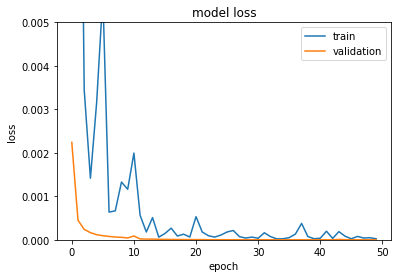

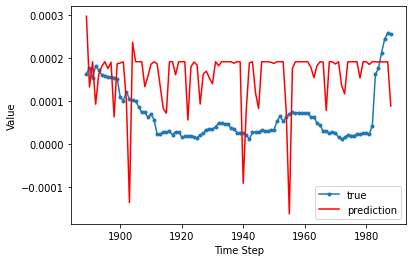

In [ ]:
# Results with MLP
y_pred= model.predict(x_val)

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,0.005)
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Price_MLP_val_2.png')
plt.show()

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();

In [ ]:
# Convert the data shape into 3-Dimensional for LSTM

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_val =x_val.reshape(x_val.shape[0],x_val.shape[1] , 1)

In [22]:
#LSTM

from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout, LSTM

def train_predict_LSTM_model(x_train, y_train ):
 
  input_shape = ( 100,1)

  # Create the model
  model = Sequential()
  model.add(LSTM(30, dropout=0.15, activation ='relu', input_shape=input_shape))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

  #Results with LSTM
  return model

trains = []
tests = []
cv = KFold(n_splits=5, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = np.array(X)[train_index], np.array(X)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    #reshape for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test =X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    #Get the trained model
    model = train_predict_LSTM_model(X_train, y_train)
    #loss1, accuracy1 = model.evaluate(X_train, y_train)
    loss2, accuracy2 = model.evaluate(X_test, y_test)
    #print(model.metrics_names, accuracy1)
    #print(model.metrics_names, accuracy2)
    #trains.append(accuracy1) # add  squared=True for RMSE
    tests.append(accuracy2)

#print(" TRAIN mean score with std error:", np.mean(trains), np.var(trains))
print(" TEST mean score with std error:", np.mean(tests), np.var(tests))

Epoch 1/20
121/121 [==============================] - 4s 35ms/step - loss: 0.6907 - accuracy: 0.5439 - val_loss: 0.6948 - val_accuracy: 0.5132
Epoch 2/20
121/121 [==============================] - 4s 33ms/step - loss: 0.6899 - accuracy: 0.5439 - val_loss: 0.6944 - val_accuracy: 0.5132
Epoch 3/20
121/121 [==============================] - 4s 32ms/step - loss: 0.6897 - accuracy: 0.5439 - val_loss: 0.6927 - val_accuracy: 0.5132
Epoch 4/20
121/121 [==============================] - 4s 32ms/step - loss: 0.6901 - accuracy: 0.5439 - val_loss: 0.6942 - val_accuracy: 0.5132
Epoch 5/20
121/121 [==============================] - 4s 33ms/step - loss: 0.6893 - accuracy: 0.5439 - val_loss: 0.6942 - val_accuracy: 0.5132
Epoch 6/20
121/121 [==============================] - 4s 33ms/step - loss: 0.6894 - accuracy: 0.5439 - val_loss: 0.6935 - val_accuracy: 0.5132
Epoch 7/20
121/121 [==============================] - 4s 32ms/step - loss: 0.6899 - accuracy: 0.5439 - val_loss: 0.6938 - val_accuracy: 0.5132